# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

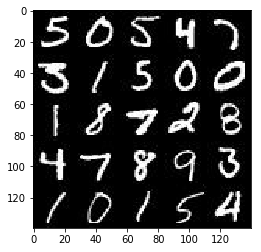

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

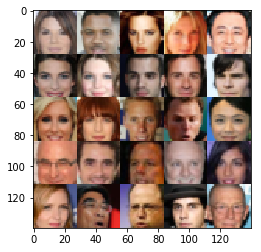

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Note: Added alpha and keep_prob by myself
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with (tf.variable_scope('discriminator', reuse=reuse)):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop2 = tf.nn.dropout(x2, keep_prob)
        bn2 = tf.layers.batch_normalization(drop2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        drop3 = tf.nn.dropout(x3, keep_prob)
        bn3 = tf.layers.batch_normalization(drop3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
# Note: Din't add keep_prob with a dropout layer here.
# Also, try with xavier initialization.
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with (tf.variable_scope('generator', reuse=not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_vars = tf.trainable_variables()
    d_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in training_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train \
                            .AdamOptimizer(learning_rate, beta1=beta1) \
                            .minimize(d_loss, var_list=d_vars)
                
        g_train_opt = tf.train \
                            .AdamOptimizer(learning_rate, beta1=beta1) \
                            .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

Example train losses when using 1 step each for G and D.

```
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 2.8536
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 7.6920
Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 2.1167
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 5.7633
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 10.8242
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 6.1633
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 2.2379... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 5.0067
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 4.0127
```

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          show_every=100, print_every=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Get a sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers for discriminator and generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # As per one of the hacks mentioned at https://github.com/soumith/ganhacks
                # Adding an extra traing step for generator because generator loss is getting very high
                # when running 1 step each for D and G. This additional step will help generator 
                # catch up with discriminator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                # Printing loss for every 10 steps (print_every)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # Show the generator output for every 100 steps (show_every).
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
Epoch 1/4... Discriminator Loss: 1.0153... Generator Loss: 0.9192
Epoch 1/4... Discriminator Loss: 1.7173... Generator Loss: 0.5585
Epoch 1/4... Discriminator Loss: 1.1006... Generator Loss: 1.4918
Epoch 1/4... Discriminator Loss: 0.5486... Generator Loss: 2.1386
Epoch 1/4... Discriminator Loss: 0.2061... Generator Loss: 2.8301
Epoch 1/4... Discriminator Loss: 0.1333... Generator Loss: 2.7957
Epoch 1/4... Discriminator Loss: 0.1209... Generator Loss: 3.7040
Epoch 1/4... Discriminator Loss: 0.0298... Generator Loss: 6.5612
Epoch 1/4... Discriminator Loss: 0.2060... Generator Loss: 2.3444
Epoch 1/4... Discriminator Loss: 2.2294... Generator Loss: 0.1687


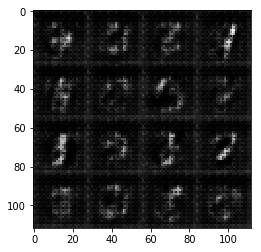

Epoch 1/4... Discriminator Loss: 0.0206... Generator Loss: 6.4410
Epoch 1/4... Discriminator Loss: 0.8931... Generator Loss: 0.8744
Epoch 1/4... Discriminator Loss: 1.4772... Generator Loss: 0.5290
Epoch 1/4... Discriminator Loss: 0.5349... Generator Loss: 1.8857
Epoch 1/4... Discriminator Loss: 0.1306... Generator Loss: 4.5048
Epoch 1/4... Discriminator Loss: 0.2688... Generator Loss: 2.5077
Epoch 1/4... Discriminator Loss: 0.2633... Generator Loss: 2.4488
Epoch 1/4... Discriminator Loss: 0.7886... Generator Loss: 2.3049
Epoch 1/4... Discriminator Loss: 0.8241... Generator Loss: 1.0255
Epoch 1/4... Discriminator Loss: 0.2061... Generator Loss: 3.4268


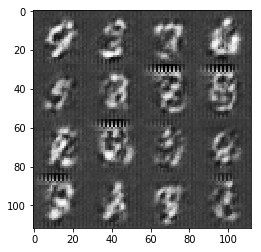

Epoch 1/4... Discriminator Loss: 0.7787... Generator Loss: 0.9643
Epoch 1/4... Discriminator Loss: 0.8933... Generator Loss: 0.8562
Epoch 1/4... Discriminator Loss: 0.2475... Generator Loss: 2.7500
Epoch 1/4... Discriminator Loss: 0.2978... Generator Loss: 7.5710
Epoch 1/4... Discriminator Loss: 0.2864... Generator Loss: 3.5735
Epoch 1/4... Discriminator Loss: 0.7629... Generator Loss: 1.0716
Epoch 1/4... Discriminator Loss: 0.2520... Generator Loss: 3.3730
Epoch 1/4... Discriminator Loss: 1.2258... Generator Loss: 0.4877
Epoch 1/4... Discriminator Loss: 1.1990... Generator Loss: 0.5669
Epoch 1/4... Discriminator Loss: 1.6089... Generator Loss: 0.3493


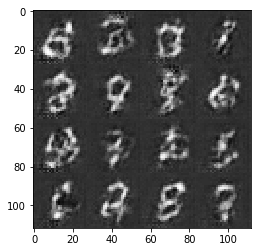

Epoch 1/4... Discriminator Loss: 0.8616... Generator Loss: 2.1680
Epoch 1/4... Discriminator Loss: 0.0704... Generator Loss: 4.8292
Epoch 1/4... Discriminator Loss: 0.4152... Generator Loss: 3.4339
Epoch 1/4... Discriminator Loss: 0.2916... Generator Loss: 1.8972
Epoch 1/4... Discriminator Loss: 0.6045... Generator Loss: 1.3497
Epoch 1/4... Discriminator Loss: 0.6991... Generator Loss: 1.3135
Epoch 1/4... Discriminator Loss: 0.2085... Generator Loss: 3.5126
Epoch 1/4... Discriminator Loss: 0.2104... Generator Loss: 4.1000
Epoch 1/4... Discriminator Loss: 0.6295... Generator Loss: 1.2936
Epoch 1/4... Discriminator Loss: 0.0901... Generator Loss: 4.7043


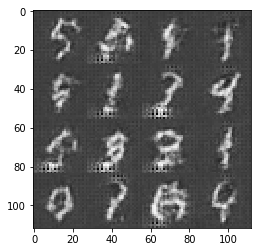

Epoch 1/4... Discriminator Loss: 0.6432... Generator Loss: 2.3766
Epoch 1/4... Discriminator Loss: 0.2243... Generator Loss: 2.9946
Epoch 1/4... Discriminator Loss: 1.3053... Generator Loss: 0.4259
Epoch 1/4... Discriminator Loss: 0.7530... Generator Loss: 1.0630
Epoch 1/4... Discriminator Loss: 0.5938... Generator Loss: 4.2300
Epoch 1/4... Discriminator Loss: 1.2961... Generator Loss: 0.6599
Epoch 2/4... Discriminator Loss: 0.4977... Generator Loss: 1.4947
Epoch 2/4... Discriminator Loss: 0.8702... Generator Loss: 0.9350
Epoch 2/4... Discriminator Loss: 2.0129... Generator Loss: 0.2577
Epoch 2/4... Discriminator Loss: 1.7539... Generator Loss: 0.3049


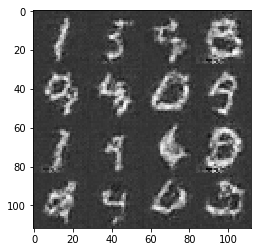

Epoch 2/4... Discriminator Loss: 0.3736... Generator Loss: 2.2254
Epoch 2/4... Discriminator Loss: 0.7557... Generator Loss: 1.1052
Epoch 2/4... Discriminator Loss: 1.6866... Generator Loss: 0.3146
Epoch 2/4... Discriminator Loss: 0.7883... Generator Loss: 0.8747
Epoch 2/4... Discriminator Loss: 0.2164... Generator Loss: 2.9164
Epoch 2/4... Discriminator Loss: 0.4499... Generator Loss: 3.1705
Epoch 2/4... Discriminator Loss: 2.0602... Generator Loss: 0.2134
Epoch 2/4... Discriminator Loss: 1.3422... Generator Loss: 0.9377
Epoch 2/4... Discriminator Loss: 0.9279... Generator Loss: 1.4431
Epoch 2/4... Discriminator Loss: 0.6084... Generator Loss: 1.0120


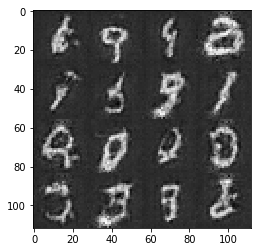

Epoch 2/4... Discriminator Loss: 0.4024... Generator Loss: 6.7467
Epoch 2/4... Discriminator Loss: 0.9472... Generator Loss: 0.7200
Epoch 2/4... Discriminator Loss: 0.2737... Generator Loss: 2.2277
Epoch 2/4... Discriminator Loss: 0.3067... Generator Loss: 5.1223
Epoch 2/4... Discriminator Loss: 2.3867... Generator Loss: 0.2939
Epoch 2/4... Discriminator Loss: 0.4431... Generator Loss: 1.6275
Epoch 2/4... Discriminator Loss: 0.9973... Generator Loss: 0.7483
Epoch 2/4... Discriminator Loss: 1.2368... Generator Loss: 0.5359
Epoch 2/4... Discriminator Loss: 0.3879... Generator Loss: 3.2115
Epoch 2/4... Discriminator Loss: 2.0248... Generator Loss: 0.2224


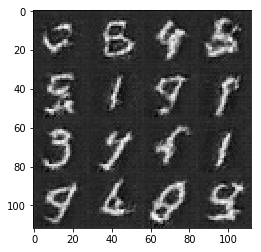

Epoch 2/4... Discriminator Loss: 0.9816... Generator Loss: 3.3844
Epoch 2/4... Discriminator Loss: 0.6473... Generator Loss: 10.1592
Epoch 2/4... Discriminator Loss: 0.4629... Generator Loss: 1.5011
Epoch 2/4... Discriminator Loss: 1.4298... Generator Loss: 0.5279
Epoch 2/4... Discriminator Loss: 0.2408... Generator Loss: 2.2900
Epoch 2/4... Discriminator Loss: 0.0913... Generator Loss: 3.6868
Epoch 2/4... Discriminator Loss: 1.3676... Generator Loss: 0.5676
Epoch 2/4... Discriminator Loss: 0.3756... Generator Loss: 2.0333
Epoch 2/4... Discriminator Loss: 0.7897... Generator Loss: 0.9731
Epoch 2/4... Discriminator Loss: 1.2268... Generator Loss: 0.4867


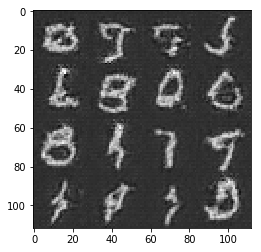

Epoch 2/4... Discriminator Loss: 0.4871... Generator Loss: 1.5151
Epoch 2/4... Discriminator Loss: 1.0326... Generator Loss: 0.7242
Epoch 2/4... Discriminator Loss: 0.6074... Generator Loss: 1.1326
Epoch 2/4... Discriminator Loss: 5.4143... Generator Loss: 2.2873
Epoch 2/4... Discriminator Loss: 0.9250... Generator Loss: 1.0686
Epoch 2/4... Discriminator Loss: 0.8753... Generator Loss: 0.9296
Epoch 2/4... Discriminator Loss: 0.9768... Generator Loss: 0.8195
Epoch 2/4... Discriminator Loss: 2.8067... Generator Loss: 0.0977
Epoch 2/4... Discriminator Loss: 0.6168... Generator Loss: 4.5232
Epoch 2/4... Discriminator Loss: 0.7969... Generator Loss: 1.0346


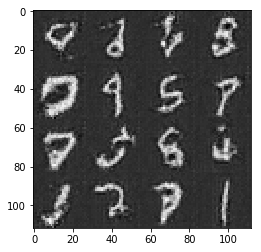

Epoch 2/4... Discriminator Loss: 0.1911... Generator Loss: 2.6902
Epoch 2/4... Discriminator Loss: 0.0668... Generator Loss: 4.3886
Epoch 2/4... Discriminator Loss: 0.1899... Generator Loss: 2.7494
Epoch 3/4... Discriminator Loss: 0.2115... Generator Loss: 5.8632
Epoch 3/4... Discriminator Loss: 1.4107... Generator Loss: 0.4561
Epoch 3/4... Discriminator Loss: 0.4482... Generator Loss: 4.8995
Epoch 3/4... Discriminator Loss: 0.7527... Generator Loss: 1.0380
Epoch 3/4... Discriminator Loss: 0.7096... Generator Loss: 1.2072
Epoch 3/4... Discriminator Loss: 0.0659... Generator Loss: 4.6662
Epoch 3/4... Discriminator Loss: 6.3510... Generator Loss: 3.5486


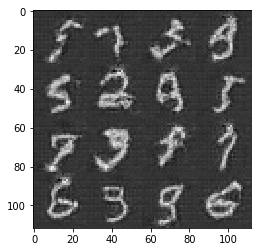

Epoch 3/4... Discriminator Loss: 1.2618... Generator Loss: 3.1427
Epoch 3/4... Discriminator Loss: 0.3512... Generator Loss: 2.5882
Epoch 3/4... Discriminator Loss: 0.5460... Generator Loss: 1.2583
Epoch 3/4... Discriminator Loss: 1.0848... Generator Loss: 0.5849
Epoch 3/4... Discriminator Loss: 0.9188... Generator Loss: 1.0213
Epoch 3/4... Discriminator Loss: 0.9646... Generator Loss: 2.5281
Epoch 3/4... Discriminator Loss: 0.8101... Generator Loss: 1.2057
Epoch 3/4... Discriminator Loss: 0.9724... Generator Loss: 0.7963
Epoch 3/4... Discriminator Loss: 0.8094... Generator Loss: 0.8852
Epoch 3/4... Discriminator Loss: 0.4581... Generator Loss: 4.7993


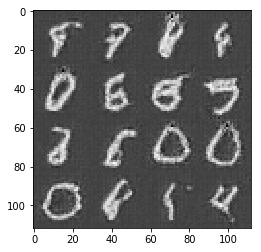

Epoch 3/4... Discriminator Loss: 1.2255... Generator Loss: 1.5116
Epoch 3/4... Discriminator Loss: 1.3198... Generator Loss: 2.3372
Epoch 3/4... Discriminator Loss: 0.5849... Generator Loss: 2.4831
Epoch 3/4... Discriminator Loss: 0.5138... Generator Loss: 1.9598
Epoch 3/4... Discriminator Loss: 0.2634... Generator Loss: 2.4052
Epoch 3/4... Discriminator Loss: 0.4198... Generator Loss: 7.7532
Epoch 3/4... Discriminator Loss: 0.3976... Generator Loss: 3.9688
Epoch 3/4... Discriminator Loss: 0.4860... Generator Loss: 1.5298
Epoch 3/4... Discriminator Loss: 0.8650... Generator Loss: 1.0378
Epoch 3/4... Discriminator Loss: 0.2671... Generator Loss: 3.6186


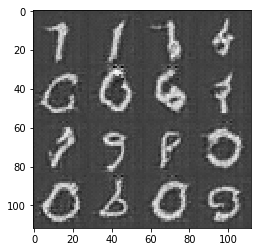

Epoch 3/4... Discriminator Loss: 1.0934... Generator Loss: 0.8295
Epoch 3/4... Discriminator Loss: 0.9147... Generator Loss: 1.2356
Epoch 3/4... Discriminator Loss: 2.5490... Generator Loss: 1.6461
Epoch 3/4... Discriminator Loss: 0.9020... Generator Loss: 2.3513
Epoch 3/4... Discriminator Loss: 0.6768... Generator Loss: 1.1896
Epoch 3/4... Discriminator Loss: 0.3570... Generator Loss: 1.8038
Epoch 3/4... Discriminator Loss: 0.3401... Generator Loss: 2.5236
Epoch 3/4... Discriminator Loss: 0.8312... Generator Loss: 1.8886
Epoch 3/4... Discriminator Loss: 0.7980... Generator Loss: 1.0915
Epoch 3/4... Discriminator Loss: 0.5419... Generator Loss: 1.4285


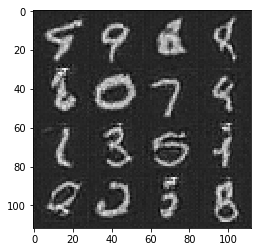

Epoch 3/4... Discriminator Loss: 0.1136... Generator Loss: 5.3800
Epoch 3/4... Discriminator Loss: 0.4354... Generator Loss: 1.9278
Epoch 3/4... Discriminator Loss: 1.1513... Generator Loss: 0.6123
Epoch 3/4... Discriminator Loss: 0.6365... Generator Loss: 5.3551
Epoch 3/4... Discriminator Loss: 1.3933... Generator Loss: 0.5291
Epoch 3/4... Discriminator Loss: 0.1751... Generator Loss: 4.4472
Epoch 3/4... Discriminator Loss: 0.1591... Generator Loss: 4.1053
Epoch 3/4... Discriminator Loss: 0.9905... Generator Loss: 1.7550
Epoch 3/4... Discriminator Loss: 0.7819... Generator Loss: 1.1511
Epoch 3/4... Discriminator Loss: 0.3622... Generator Loss: 8.4108


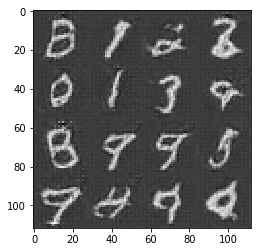

Epoch 4/4... Discriminator Loss: 0.4728... Generator Loss: 1.6940
Epoch 4/4... Discriminator Loss: 0.5540... Generator Loss: 1.2157
Epoch 4/4... Discriminator Loss: 0.3883... Generator Loss: 7.2617
Epoch 4/4... Discriminator Loss: 0.4962... Generator Loss: 1.3903
Epoch 4/4... Discriminator Loss: 0.2088... Generator Loss: 4.2281
Epoch 4/4... Discriminator Loss: 1.2234... Generator Loss: 0.8080
Epoch 4/4... Discriminator Loss: 0.5114... Generator Loss: 1.5910
Epoch 4/4... Discriminator Loss: 0.0723... Generator Loss: 3.7658
Epoch 4/4... Discriminator Loss: 1.1277... Generator Loss: 5.9566
Epoch 4/4... Discriminator Loss: 0.1880... Generator Loss: 2.9915


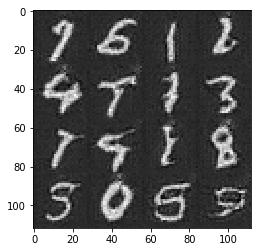

Epoch 4/4... Discriminator Loss: 0.1307... Generator Loss: 4.8461
Epoch 4/4... Discriminator Loss: 0.0341... Generator Loss: 4.9814
Epoch 4/4... Discriminator Loss: 1.0587... Generator Loss: 1.0783
Epoch 4/4... Discriminator Loss: 1.0956... Generator Loss: 0.7844
Epoch 4/4... Discriminator Loss: 0.5716... Generator Loss: 1.4766
Epoch 4/4... Discriminator Loss: 0.6779... Generator Loss: 1.3820
Epoch 4/4... Discriminator Loss: 2.3694... Generator Loss: 4.3992
Epoch 4/4... Discriminator Loss: 0.9219... Generator Loss: 1.5428
Epoch 4/4... Discriminator Loss: 0.6542... Generator Loss: 1.5686
Epoch 4/4... Discriminator Loss: 0.2672... Generator Loss: 6.6549


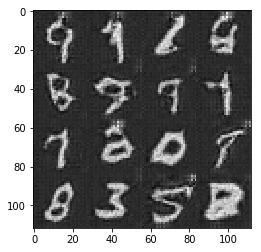

Epoch 4/4... Discriminator Loss: 0.4011... Generator Loss: 1.8184
Epoch 4/4... Discriminator Loss: 1.3415... Generator Loss: 0.4964
Epoch 4/4... Discriminator Loss: 0.8097... Generator Loss: 1.1243
Epoch 4/4... Discriminator Loss: 2.0965... Generator Loss: 0.3026
Epoch 4/4... Discriminator Loss: 0.4763... Generator Loss: 1.5577
Epoch 4/4... Discriminator Loss: 1.0298... Generator Loss: 0.8319
Epoch 4/4... Discriminator Loss: 0.0536... Generator Loss: 4.3444
Epoch 4/4... Discriminator Loss: 2.0741... Generator Loss: 0.2667
Epoch 4/4... Discriminator Loss: 1.0891... Generator Loss: 1.1359
Epoch 4/4... Discriminator Loss: 1.0674... Generator Loss: 1.4607


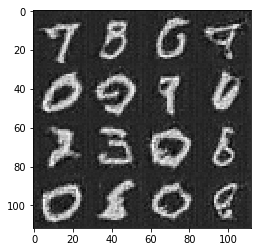

Epoch 4/4... Discriminator Loss: 1.5446... Generator Loss: 0.4162
Epoch 4/4... Discriminator Loss: 1.8499... Generator Loss: 3.4611
Epoch 4/4... Discriminator Loss: 0.8480... Generator Loss: 0.9752
Epoch 4/4... Discriminator Loss: 0.7591... Generator Loss: 1.4942
Epoch 4/4... Discriminator Loss: 1.1676... Generator Loss: 0.6720
Epoch 4/4... Discriminator Loss: 0.3262... Generator Loss: 3.4387
Epoch 4/4... Discriminator Loss: 0.5881... Generator Loss: 1.2087
Epoch 4/4... Discriminator Loss: 0.9858... Generator Loss: 0.8255
Epoch 4/4... Discriminator Loss: 0.4535... Generator Loss: 1.7134
Epoch 4/4... Discriminator Loss: 1.4967... Generator Loss: 0.4484


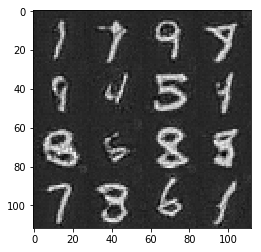

Epoch 4/4... Discriminator Loss: 1.1728... Generator Loss: 0.6376
Epoch 4/4... Discriminator Loss: 0.4157... Generator Loss: 1.5054
Epoch 4/4... Discriminator Loss: 1.4178... Generator Loss: 0.4169
Epoch 4/4... Discriminator Loss: 1.1735... Generator Loss: 0.7243
Epoch 4/4... Discriminator Loss: 1.0160... Generator Loss: 1.5048
Epoch 4/4... Discriminator Loss: 0.7258... Generator Loss: 2.3306
Epoch 4/4... Discriminator Loss: 0.8371... Generator Loss: 1.4141


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
Epoch 1/8... Discriminator Loss: 0.1190... Generator Loss: 3.0600
Epoch 1/8... Discriminator Loss: 0.0697... Generator Loss: 5.4958
Epoch 1/8... Discriminator Loss: 1.6116... Generator Loss: 1.7283
Epoch 1/8... Discriminator Loss: 0.6036... Generator Loss: 9.3672
Epoch 1/8... Discriminator Loss: 0.9983... Generator Loss: 0.8577
Epoch 1/8... Discriminator Loss: 1.3280... Generator Loss: 6.5203
Epoch 1/8... Discriminator Loss: 0.2485... Generator Loss: 7.9220
Epoch 1/8... Discriminator Loss: 0.0707... Generator Loss: 4.9135
Epoch 1/8... Discriminator Loss: 1.7353... Generator Loss: 0.5728
Epoch 1/8... Discriminator Loss: 1.5429... Generator Loss: 0.6401


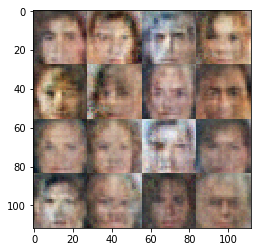

Epoch 1/8... Discriminator Loss: 1.4863... Generator Loss: 0.6234
Epoch 1/8... Discriminator Loss: 1.4752... Generator Loss: 0.6347
Epoch 1/8... Discriminator Loss: 1.4074... Generator Loss: 0.5775
Epoch 1/8... Discriminator Loss: 1.5096... Generator Loss: 0.7358
Epoch 1/8... Discriminator Loss: 0.1869... Generator Loss: 2.9973
Epoch 2/8... Discriminator Loss: 0.6023... Generator Loss: 4.9015
Epoch 2/8... Discriminator Loss: 0.6981... Generator Loss: 0.9631
Epoch 2/8... Discriminator Loss: 1.1807... Generator Loss: 1.4893
Epoch 2/8... Discriminator Loss: 1.6573... Generator Loss: 0.5329
Epoch 2/8... Discriminator Loss: 1.7834... Generator Loss: 0.5558


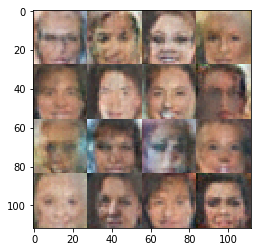

Epoch 2/8... Discriminator Loss: 1.7211... Generator Loss: 0.5160
Epoch 2/8... Discriminator Loss: 1.5632... Generator Loss: 0.5526
Epoch 2/8... Discriminator Loss: 1.6029... Generator Loss: 0.5340
Epoch 2/8... Discriminator Loss: 1.5422... Generator Loss: 0.5512
Epoch 2/8... Discriminator Loss: 1.4958... Generator Loss: 0.6303
Epoch 2/8... Discriminator Loss: 1.5865... Generator Loss: 0.5464
Epoch 2/8... Discriminator Loss: 1.4992... Generator Loss: 0.5380
Epoch 2/8... Discriminator Loss: 1.5916... Generator Loss: 0.5315
Epoch 2/8... Discriminator Loss: 1.5318... Generator Loss: 0.5515
Epoch 2/8... Discriminator Loss: 1.5209... Generator Loss: 0.5642


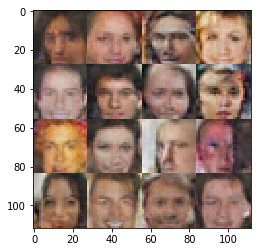

Epoch 2/8... Discriminator Loss: 1.6367... Generator Loss: 0.5723
Epoch 3/8... Discriminator Loss: 0.5986... Generator Loss: 1.2761
Epoch 3/8... Discriminator Loss: 1.3851... Generator Loss: 0.5204
Epoch 3/8... Discriminator Loss: 1.1821... Generator Loss: 0.6716
Epoch 3/8... Discriminator Loss: 0.2676... Generator Loss: 3.2353
Epoch 3/8... Discriminator Loss: 1.5240... Generator Loss: 0.6499
Epoch 3/8... Discriminator Loss: 1.4574... Generator Loss: 0.6352
Epoch 3/8... Discriminator Loss: 1.5469... Generator Loss: 0.5868
Epoch 3/8... Discriminator Loss: 1.4738... Generator Loss: 0.5801
Epoch 3/8... Discriminator Loss: 1.6028... Generator Loss: 0.6450


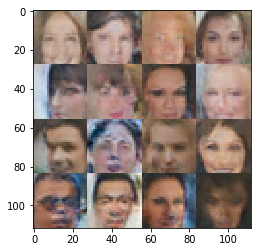

Epoch 3/8... Discriminator Loss: 1.4671... Generator Loss: 0.5628
Epoch 3/8... Discriminator Loss: 1.5335... Generator Loss: 0.5903
Epoch 3/8... Discriminator Loss: 1.5193... Generator Loss: 0.5922
Epoch 3/8... Discriminator Loss: 1.4538... Generator Loss: 0.5933
Epoch 3/8... Discriminator Loss: 1.4575... Generator Loss: 0.6013
Epoch 3/8... Discriminator Loss: 1.5503... Generator Loss: 0.5685
Epoch 3/8... Discriminator Loss: 1.5470... Generator Loss: 0.5256
Epoch 4/8... Discriminator Loss: 1.5213... Generator Loss: 0.6806
Epoch 4/8... Discriminator Loss: 1.4661... Generator Loss: 0.7144
Epoch 4/8... Discriminator Loss: 1.5381... Generator Loss: 0.5909


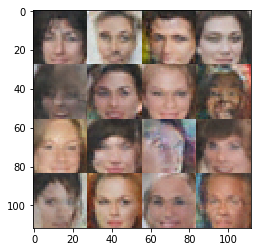

Epoch 4/8... Discriminator Loss: 1.4584... Generator Loss: 0.6399
Epoch 4/8... Discriminator Loss: 1.4003... Generator Loss: 0.6519
Epoch 4/8... Discriminator Loss: 0.0615... Generator Loss: 4.8050
Epoch 4/8... Discriminator Loss: 0.8537... Generator Loss: 8.6689
Epoch 4/8... Discriminator Loss: 1.5456... Generator Loss: 0.6049
Epoch 4/8... Discriminator Loss: 1.3968... Generator Loss: 0.6202
Epoch 4/8... Discriminator Loss: 1.5310... Generator Loss: 0.6820
Epoch 4/8... Discriminator Loss: 1.5293... Generator Loss: 0.5154
Epoch 4/8... Discriminator Loss: 1.5654... Generator Loss: 0.6697
Epoch 4/8... Discriminator Loss: 1.6652... Generator Loss: 0.6292


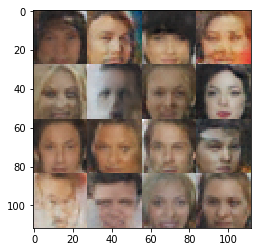

Epoch 4/8... Discriminator Loss: 1.3517... Generator Loss: 0.7185
Epoch 4/8... Discriminator Loss: 1.5563... Generator Loss: 0.6835
Epoch 4/8... Discriminator Loss: 1.4574... Generator Loss: 0.6853
Epoch 5/8... Discriminator Loss: 1.4138... Generator Loss: 0.5894
Epoch 5/8... Discriminator Loss: 1.5073... Generator Loss: 0.6194
Epoch 5/8... Discriminator Loss: 1.4501... Generator Loss: 0.6371
Epoch 5/8... Discriminator Loss: 1.5066... Generator Loss: 0.5745
Epoch 5/8... Discriminator Loss: 1.5414... Generator Loss: 0.5919
Epoch 5/8... Discriminator Loss: 0.0401... Generator Loss: 6.4512
Epoch 5/8... Discriminator Loss: 1.4473... Generator Loss: 0.5834


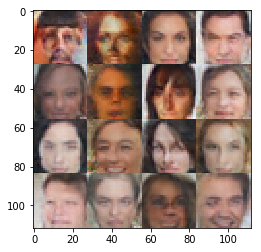

Epoch 5/8... Discriminator Loss: 1.5244... Generator Loss: 0.6061
Epoch 5/8... Discriminator Loss: 1.4665... Generator Loss: 0.5386
Epoch 5/8... Discriminator Loss: 1.4918... Generator Loss: 0.6141
Epoch 5/8... Discriminator Loss: 1.5365... Generator Loss: 0.6210
Epoch 5/8... Discriminator Loss: 1.4152... Generator Loss: 0.7610
Epoch 5/8... Discriminator Loss: 1.5484... Generator Loss: 0.5751
Epoch 5/8... Discriminator Loss: 1.4828... Generator Loss: 0.6733
Epoch 5/8... Discriminator Loss: 1.4883... Generator Loss: 0.5882
Epoch 5/8... Discriminator Loss: 1.5386... Generator Loss: 0.6439
Epoch 6/8... Discriminator Loss: 0.9003... Generator Loss: 0.8103


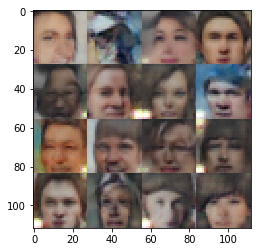

Epoch 6/8... Discriminator Loss: 1.4257... Generator Loss: 0.6222
Epoch 6/8... Discriminator Loss: 1.4989... Generator Loss: 0.7090
Epoch 6/8... Discriminator Loss: 1.5380... Generator Loss: 0.6392
Epoch 6/8... Discriminator Loss: 1.5046... Generator Loss: 0.6291
Epoch 6/8... Discriminator Loss: 1.5297... Generator Loss: 0.6560
Epoch 6/8... Discriminator Loss: 1.4305... Generator Loss: 0.6734
Epoch 6/8... Discriminator Loss: 1.3516... Generator Loss: 0.6581
Epoch 6/8... Discriminator Loss: 1.4835... Generator Loss: 0.6482
Epoch 6/8... Discriminator Loss: 1.4455... Generator Loss: 0.6154
Epoch 6/8... Discriminator Loss: 1.3165... Generator Loss: 0.7176


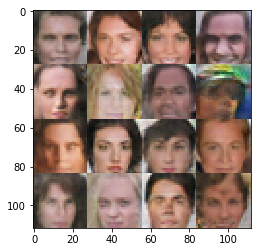

Epoch 6/8... Discriminator Loss: 1.5612... Generator Loss: 0.6080
Epoch 6/8... Discriminator Loss: 1.3930... Generator Loss: 0.7248
Epoch 6/8... Discriminator Loss: 1.4525... Generator Loss: 0.5954
Epoch 6/8... Discriminator Loss: 1.4350... Generator Loss: 0.6605
Epoch 7/8... Discriminator Loss: 1.3626... Generator Loss: 0.7031
Epoch 7/8... Discriminator Loss: 1.5188... Generator Loss: 0.6407
Epoch 7/8... Discriminator Loss: 1.5940... Generator Loss: 0.5889
Epoch 7/8... Discriminator Loss: 1.4769... Generator Loss: 0.5951
Epoch 7/8... Discriminator Loss: 1.4452... Generator Loss: 0.5961
Epoch 7/8... Discriminator Loss: 1.5056... Generator Loss: 0.6049


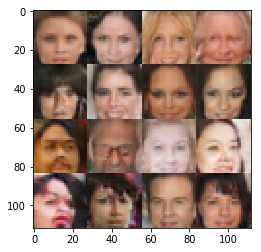

Epoch 7/8... Discriminator Loss: 1.3860... Generator Loss: 0.7061
Epoch 7/8... Discriminator Loss: 1.5307... Generator Loss: 0.5682
Epoch 7/8... Discriminator Loss: 1.3696... Generator Loss: 0.6417
Epoch 7/8... Discriminator Loss: 1.3973... Generator Loss: 0.6489
Epoch 7/8... Discriminator Loss: 1.3770... Generator Loss: 0.6557
Epoch 7/8... Discriminator Loss: 1.4812... Generator Loss: 0.6093
Epoch 7/8... Discriminator Loss: 1.4180... Generator Loss: 0.6665
Epoch 7/8... Discriminator Loss: 1.5040... Generator Loss: 0.6644
Epoch 7/8... Discriminator Loss: 1.4113... Generator Loss: 0.7129
Epoch 7/8... Discriminator Loss: 1.4873... Generator Loss: 0.6662


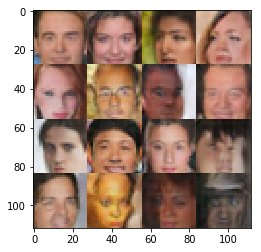

Epoch 8/8... Discriminator Loss: 1.4065... Generator Loss: 0.6793
Epoch 8/8... Discriminator Loss: 1.3972... Generator Loss: 0.6463
Epoch 8/8... Discriminator Loss: 1.4276... Generator Loss: 0.5867
Epoch 8/8... Discriminator Loss: 1.5180... Generator Loss: 0.6401
Epoch 8/8... Discriminator Loss: 1.4275... Generator Loss: 0.6516
Epoch 8/8... Discriminator Loss: 1.4541... Generator Loss: 0.5983
Epoch 8/8... Discriminator Loss: 1.4927... Generator Loss: 0.6258
Epoch 8/8... Discriminator Loss: 1.4361... Generator Loss: 0.7045
Epoch 8/8... Discriminator Loss: 1.4273... Generator Loss: 0.6321
Epoch 8/8... Discriminator Loss: 1.4148... Generator Loss: 0.6006


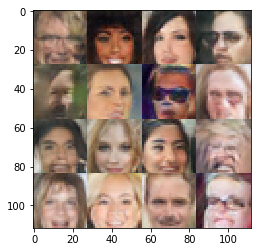

Epoch 8/8... Discriminator Loss: 1.4876... Generator Loss: 0.5762
Epoch 8/8... Discriminator Loss: 1.4362... Generator Loss: 0.6162
Epoch 8/8... Discriminator Loss: 1.5075... Generator Loss: 0.5889
Epoch 8/8... Discriminator Loss: 1.4820... Generator Loss: 0.6163
Epoch 8/8... Discriminator Loss: 1.5316... Generator Loss: 0.5808
Epoch 8/8... Discriminator Loss: 1.4641... Generator Loss: 0.6426


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Running it for 8 epochs to generate slightly realistic faces.
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=1000, print_every=100)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.